### obs: made/tested for python 3.5!

In [1]:
%matplotlib inline 
%matplotlib nbagg
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from data_generator import get_batch, print_valid_characters, valid_characters
from tensorflow.python.framework.ops import reset_default_graph
import tf_utils

# NOTE:
# importing custom tf kernel containing sparsemax op.
# assumes existance of a ../../tensorflow_sparsemax/kernel
# containing a compiled sparsemax kernel
import os.path as path
import sys

thisdir = path.dirname(path.realpath("__file__"))
sys.path.append(path.join(thisdir, '../../tensorflow_sparsemax'))

import kernel

# Recurrent Neural Networks

Recurrent neural networks are the natural type of neural network to use for sequential data i.e. time series analysis, translation, speech recognition, biological sequence analysis etc. Recurrent neural networks works by recursively applying the same operation at each time step of the data sequence and having layers that pass information from previous time step to the current. It can therefore naturally handle input of varying length. Recurrent networks can be used for several prediction tasks including: sequence-to-class, sequence tagging, and sequence-to-sequence predictions.

In this test we will build a naive version of the [Bahdanau et al., 2014 model](https://arxiv.org/abs/1409.0473) using either softmax or **sparse_max** for attention.

This type of models have shown impressive performance in Neural Machine Translation and Image Caption generation.

For more in depth background material on RNNs please see [Supervised Sequence Labelling with Recurrent
Neural Networks](https://www.cs.toronto.edu/~graves/preprint.pdf) by Alex Graves

We know that LSTMs and GRUs are difficult to understand. A very good non-mathematical introduction is [Chris Olahs blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). (All the posts are nice and cover various topics within machine-learning).

# Encoder-Decoder
In the encoder-decoder structure one RNN (blue) encodes the input and a second RNN (red) calculates the target values. One essential step is to let the encoder and decoder communicate. In the simplest approach you use the last hidden state of the encoder to initialize the decoder. Other approaches lets the decoder attend to different parts of the encoded input at different timesteps in the decoding process. 

<img src="files/enc-dec.png", width=400>

In our implementation we use a RNN with gated recurrent units (GRU) as encoder. We then use the last hidden state of the encoder ($h^{enc}_T$) as input to the decoder which is also a GRU RNN. 

### RNNs in TensorFlow
TensorFlow has implementations of LSTM and GRU units.
Both implementations assume that the input from the tensor below has the shape **(batch_size, seq_len, num_features)**, unless you have `time_major=True`.
In this test we will use the GRU unit since it only stores a single hidden value per neuron (LSTMs stores two) and is approximately twice as fast as the LSTM unit.

### The Data
Since RNN models can be very slow to train on real large datasets we will generate some simpler training data for this exercise. The task for the RNN is simply to translate a string of letters spelling the numbers between 0-9 into the corresponding numbers i.e

"one two five" --> "125#" (we use # as a special end-of-sequence character)

To input the strings into the RNN model we translate the characters into a vector integers using a simple translation table (i.e. 'h'->16, 'o'-> 17 etc). The code below prints a few input/output pairs using the *get_batch* function which randomy produces the data.

Do note; that as showed in the illustration above for input to the decoder the end-of-sequence tag is flipped, and used in the beginning instead of the end. This tag is known as start-of-sequence, but often the end-of-sequence tag is just reused for this purpose.

In the data loader below you will see two targets, target input and target output. Where the input will be used to compute the translation and output used for the loss function.

In [2]:
batch_size = 3
inputs, inputs_seqlen, targets_in, targets_out, targets_seqlen, targets_mask, \
text_inputs, text_targets_in, text_targets_out = \
    get_batch(batch_size=batch_size, max_digits=2, min_digits=1)

print("input types:", inputs.dtype, inputs_seqlen.dtype, targets_in.dtype, targets_out.dtype, targets_seqlen.dtype)
print(print_valid_characters())
print("Stop/start character = #")

for i in range(batch_size):
    print("\nSAMPLE",i)
    print("TEXT INPUTS:\t\t\t", text_inputs[i])
    print("TEXT TARGETS INPUT:\t\t", text_targets_in[i])
    print("TEXT TARGETS OUTPUT:\t\t", text_targets_out[i])
    print("ENCODED INPUTS:\t\t\t", inputs[i])
    print("INPUTS SEQUENCE LENGTH:\t\t", inputs_seqlen[i])
    print("ENCODED TARGETS INPUT:\t\t", targets_in[i])
    print("ENCODED TARGETS OUTPUT:\t\t", targets_out[i])
    print("TARGETS SEQUENCE LENGTH:\t", targets_seqlen[i])
    print("TARGETS MASK:\t\t\t", targets_mask[i])

input types: int32 int32 int32 int32 int32
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	'g'=11,	'o'=12,	'i'=13,	'r'=14,	'f'=15,	'u'=16,	'n'=17,	'h'=18,	'v'=19,	'e'=20,	's'=21,	'w'=22,	't'=23,	' '=24,	'z'=25,	'x'=26,	
None
Stop/start character = #

SAMPLE 0
TEXT INPUTS:			 three
TEXT TARGETS INPUT:		 #3
TEXT TARGETS OUTPUT:		 3#
ENCODED INPUTS:			 [23 18 14 20 20]
INPUTS SEQUENCE LENGTH:		 5
ENCODED TARGETS INPUT:		 [10  3]
ENCODED TARGETS OUTPUT:		 [ 3 10]
TARGETS SEQUENCE LENGTH:	 2
TARGETS MASK:			 [ 1.  1.]

SAMPLE 1
TEXT INPUTS:			 seven
TEXT TARGETS INPUT:		 #7
TEXT TARGETS OUTPUT:		 7#
ENCODED INPUTS:			 [21 20 19 20 17]
INPUTS SEQUENCE LENGTH:		 5
ENCODED TARGETS INPUT:		 [10  7]
ENCODED TARGETS OUTPUT:		 [ 7 10]
TARGETS SEQUENCE LENGTH:	 2
TARGETS MASK:			 [ 1.  1.]

SAMPLE 2
TEXT INPUTS:			 four
TEXT TARGETS INPUT:		 #4
TEXT TARGETS OUTPUT:		 4#
ENCODED INPUTS:			 [15 12 16 14  0]
INPUTS SEQUENCE LENGTH:		 4
ENCOD

## Attention Decoder (LSTM)
Soft attention for recurrent neural networks have recently attracted a lot of interest.
These methods let the Decoder model selective focus on which part of the encoder sequence it will use for each decoded output symbol.
This relieves the encoder from having to compress the input sequence into a fixed size vector representation passed on to the decoder.
Secondly we can interrogate the decoder network about where it attends while producing the ouputs.
below we'll implement an LSTM-decoder with both softmax and **sparse_max** to show the different attention outputs.

The principle of attention models is simple. 

1. Use the encoder to get the hidden represention $\{h^1_e, ...h^n_e\}$ for each position in the input sequence. 
2. for timestep $t$ in the decoder do for $m = 1...n$ : $a_m = f(h^m_e, h^d_t)$. Where f is a function returning a scalar value. 
3. You can then normalize the sequence of scalars $\{a_1, ... a_n\}$ to get probablities $\{p_1, ... p_n\}$ with either softmax or **sparse_max**.
4. Weight each $h^e_t$ by its probablity $p_t$ and sum to get $h_{in}$.
5. Use $h_{in}$ as an additional input to the decoder. $h_{in}$ is recalculated each time the decoder is updated.

In [3]:
#define loss function
def loss_and_acc(preds):
    # sequence_loss_tensor is a modification of TensorFlow's own sequence_to_sequence_loss
    # TensorFlow's seq2seq loss works with a 2D list instead of a 3D tensors
    loss = tf_utils.sequence_loss_tensor(preds, ts_out, t_mask, NUM_OUTPUTS) # notice that we use ts_out here!
    # if you want regularization
    reg_scale = 0.00001
    regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    reg_term = sum([regularize(param) for param in params])
    loss += reg_term
    # calculate accuracy
    argmax = tf.to_int32(tf.argmax(preds, 2))
    correct = tf.to_float(tf.equal(argmax, tf.to_int32(ts_out))) * t_mask
    accuracy = tf.reduce_sum(correct) / tf.reduce_sum(t_mask)
    return loss, accuracy, argmax


In [4]:
# resetting the graph
reset_default_graph()
tf.set_random_seed(13)
# Setting up hyperparameters and general configs
MAX_DIGITS = 5
MIN_DIGITS = 5
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')

BATCH_SIZE = 100
# try various learning rates 1e-2 to 1e-5
LEARNING_RATE = 0.005
X_EMBEDDINGS = 8
t_EMBEDDINGS = 8
NUM_UNITS_ENC = 10
NUM_UNITS_DEC = 10
NUM_UNITS_ATTN = 20


# Setting up placeholders, these are the tensors that we "feed" to our network
Xs = tf.placeholder(tf.int32, shape=[None, None], name='X_input')
ts_in = tf.placeholder(tf.int32, shape=[None, None], name='t_input_in')
ts_out = tf.placeholder(tf.int32, shape=[None, None], name='t_input_out')
X_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_mask = tf.placeholder(tf.float32, shape=[None, None], name='t_mask')

# Building the model



class RNN:    
    def __init__(self, method):
        """
        Sets up an rnn using soft- or sparsemax

        Parameters
        ----
        method: string ['softmax' or 'sparsemax']

        Returns
        -----
        {'train': y, 'validation': y_valid} (trainable / validation tensor)
        """
        
        attention = None
        if method == 'softmax':
            attention = tf.nn.softmax
        elif method == "sparsemax":
            attention = kernel.sparsemax
        else:
            raise ValueError("method must be 'softmax' or 'sparsemax'")
        
        self.method = method
        
        
        # first we build the embeddings to make our characters into dense, trainable vectors
        self.X_embeddings = tf.get_variable('X_embeddings_' + self.method, [NUM_INPUTS, X_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))
        self.t_embeddings = tf.get_variable('t_embeddings_' + self.method, [NUM_OUTPUTS, t_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))
        
        # setting up weights for computing the final output
        self.W_out = tf.get_variable('W_out_' + self.method, [NUM_UNITS_DEC, NUM_OUTPUTS])
        self.b_out = tf.get_variable('b_out_' + self.method, [NUM_OUTPUTS])

        self.X_embedded = tf.gather(self.X_embeddings, Xs, name='embed_X' + self.method)
        self.t_embedded = tf.gather(self.t_embeddings, ts_in, name='embed_t' + self.method)

        # forward encoding
        self.enc_cell = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC)
        self.enc_out, self.enc_state = tf.nn.dynamic_rnn(cell=self.enc_cell, inputs=self.X_embedded,
                                         sequence_length=X_len, dtype=tf.float32)

        # decoding
        # note that we are using a wrapper for decoding here, this wrapper is hardcoded to only use GRU
        # check out tf_utils to see how you make your own decoder


        self.dec_out, self.dec_out_valid, self.alpha_valid = \
            tf_utils.attention_decoder(self.enc_out, X_len, self.enc_state, self.t_embedded, t_len,
                                       NUM_UNITS_DEC, NUM_UNITS_ATTN, self.t_embeddings,
                                       self.W_out, self.b_out, attention_fn=attention)

        # reshaping to have [batch_size*seqlen, num_units]
        self.out_tensor = tf.reshape(self.dec_out, [-1, NUM_UNITS_DEC])
        self.out_tensor_valid = tf.reshape(self.dec_out_valid, [-1, NUM_UNITS_DEC])
        # computing output
        self.out_tensor = tf.matmul(self.out_tensor, self.W_out) + self.b_out
        self.out_tensor_valid = tf.matmul(self.out_tensor_valid, self.W_out) + self.b_out
        # reshaping back to sequence
        b_size = tf.shape(X_len)[0] # use a variable we know has batch_size in [0]
        seq_len = tf.shape(self.t_embedded)[1] # variable we know has sequence length in [1]
        num_out = tf.constant(NUM_OUTPUTS) # casting NUM_OUTPUTS to a tensor variable
        out_shape = tf.concat(0, [tf.expand_dims(b_size, 0),
                                  tf.expand_dims(seq_len, 0),
                                  tf.expand_dims(num_out, 0)])
        self.out_tensor = tf.reshape(self.out_tensor, out_shape)
        self.out_tensor_valid = tf.reshape(self.out_tensor_valid, out_shape)
        # handling shape loss
        #out_tensor.set_shape([None, None, NUM_OUTPUTS])
        self.y = self.out_tensor
        self.y_valid = self.out_tensor_valid
        
        
        self.loss, self.accuracy, self.predictions = loss_and_acc(self.y)
        self.loss_valid, self.accuracy_valid, self.predictions_valid = loss_and_acc(self.y_valid)
        
        # use lobal step to keep track of our iterations
        self.global_step = tf.Variable(0, name='global_step_' + self.method, trainable=False)
        # pick optimizer, try momentum or adadelta
        self.optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
        # extract gradients for each variable
        self.grads_and_vars = self.optimizer.compute_gradients(self.loss)

        # add below for clipping by norm

        gradients, variables = zip(*self.grads_and_vars)  # unzip list of tuples
        clipped_gradients, self.global_norm = (
            tf.clip_by_global_norm(gradients, 1) )
        #self.grads_and_vars = zip(clipped_gradients, variables)
        # apply gradients and make trainable function
        self.train_op = self.optimizer.apply_gradients(self.grads_and_vars, global_step=self.global_step)
        
    def __repr__(self):
        return "RNN class with attention type {p.method}".format(p=self)
    
    def __print__(self):
        return self.__repr__(self)

In [5]:
reset_default_graph()
tf.set_random_seed(13)
Xs = tf.placeholder(tf.int32, shape=[None, None], name='X_input')
ts_in = tf.placeholder(tf.int32, shape=[None, None], name='t_input_in')
ts_out = tf.placeholder(tf.int32, shape=[None, None], name='t_input_out')
X_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_mask = tf.placeholder(tf.float32, shape=[None, None], name='t_mask')

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
# test train part
sess.run(tf.initialize_all_variables())
feed_dict = {Xs: inputs, X_len: inputs_seqlen, ts_in: targets_in,
             ts_out: targets_out, t_len: targets_seqlen}


model_softmax = RNN('softmax')

In [6]:
# as always, test the forward pass and start the tf.Session!
# here is some dummy data
batch_size = 3
inputs, inputs_seqlen, targets_in, targets_out, targets_seqlen, targets_mask, \
text_inputs, text_targets_in, text_targets_out = \
    get_batch(batch_size=3, max_digits=7, min_digits=2)

for i in range(batch_size):
    print("\nSAMPLE",i)
    print("TEXT INPUTS:\t\t\t", text_inputs[i])
    print("TEXT TARGETS INPUT:\t\t", text_targets_in[i])

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
# test train part
sess.run(tf.initialize_all_variables())
feed_dict = {Xs: inputs, X_len: inputs_seqlen, ts_in: targets_in,
             ts_out: targets_out, t_len: targets_seqlen}
fetches = [model_softmax.y]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y", res[0].shape)

# test validation part
fetches = [model_softmax.y_valid]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y_valid", res[0].shape)


SAMPLE 0
TEXT INPUTS:			 seven four six nine two
TEXT TARGETS INPUT:		 #74692

SAMPLE 1
TEXT INPUTS:			 seven four three seven
TEXT TARGETS INPUT:		 #7437

SAMPLE 2
TEXT INPUTS:			 five four one seven
TEXT TARGETS INPUT:		 #5417
y (3, 6, 11)
y_valid (3, 6, 11)


In [7]:
# print all the variable names and shapes
# notice that W_z is now packed, such that it contains both W_z_h and W_x_h, this is for optimization
# further, we now have W_s, b_s. This is so NUM_UNITS_ENC and NUM_UNITS_DEC does not have to share shape ..!
for var in tf.all_variables():
    s = var.name + " "*(40-len(var.name))
    print(s, var.value().get_shape())

X_embeddings_softmax:0                   (27, 8)
t_embeddings_softmax:0                   (11, 8)
W_out_softmax:0                          (10, 11)
b_out_softmax:0                          (11,)
RNN/GRUCell/Gates/Linear/Matrix:0        (18, 20)
RNN/GRUCell/Gates/Linear/Bias:0          (20,)
RNN/GRUCell/Candidate/Linear/Matrix:0    (18, 10)
RNN/GRUCell/Candidate/Linear/Bias:0      (10,)
decoder/W_s:0                            (10, 10)
decoder/b_s:0                            (10,)
decoder/W_z:0                            (28, 10)
decoder/W_r:0                            (28, 10)
decoder/W_c:0                            (28, 10)
decoder/b_z:0                            (10,)
decoder/b_r:0                            (10,)
decoder/b_c:0                            (10,)
decoder/W_a:0                            (10, 20)
decoder/U_a:0                            (1, 1, 10, 20)
decoder/b_a:0                            (20,)
decoder/v_a:0                            (20,)
global_step_softmax:0  

In [8]:
#Generate some validation data
X_val, X_len_val, t_in_val, t_out_val, t_len_val, t_mask_val, \
text_inputs_val, text_targets_in_val, text_targets_out_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
print("X_val", X_val.shape)
print("t_out_val", t_out_val.shape)

X_val (5000, 29)
t_out_val (5000, 6)


In [9]:
# NOTICE - THIS MIGHT TAKE UPTO 30 MINUTES ON CPU..!
# setting up running parameters
val_interval = 5000
samples_to_process = 1e5


def train_model(model, extra_name=""):
    samples_processed = 0
    samples_val = []
    costs, accs = [], []
    global_norms = []
    predictions = []
    plt.figure()
    try:
        while samples_processed < samples_to_process:
            # load data
            X_tr, X_len_tr, t_in_tr, t_out_tr, t_len_tr, t_mask_tr, \
            text_inputs_tr, text_targets_in_tr, text_targets_out_tr = \
                get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
            # make fetches
            fetches_tr = [model.train_op, model.loss, model.accuracy, model.global_norm, model.predictions]
            # set up feed dict
            feed_dict_tr = {Xs: X_tr, X_len: X_len_tr, ts_in: t_in_tr,
                 ts_out: t_out_tr, t_len: t_len_tr, t_mask: t_mask_tr}
            # run the model
            res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
            _, batch_cost, batch_acc, global_norm, global_predictions = res
            global_norms.append(global_norm)
            predictions.append(global_predictions)

            costs += [batch_cost]
            samples_processed += BATCH_SIZE
            #if samples_processed % 1000 == 0: print batch_cost, batch_acc
            #validation data
            if samples_processed % val_interval == 0:
                #print "validating"
                fetches_val = [model.accuracy_valid, model.y_valid, model.alpha_valid]
                feed_dict_val = {Xs: X_val, X_len: X_len_val, ts_in: t_in_val,
                 ts_out: t_out_val, t_len: t_len_val, t_mask: t_mask_val}
                res = tuple(sess.run(fetches=fetches_val, feed_dict=feed_dict_val))
                model.acc_val, model.output_val, model.alp_val = res
                ravelled = np.ravel(np.ravel(model.alp_val))
                print("Alpha: max={0:.4f}, min={1:.45}".format(max(ravelled), min(ravelled)))
                #print(model.loss, model.predictions)
                samples_val += [samples_processed]
                accs += [model.acc_val]
                plt.plot(samples_val, accs, 'b-')
                plt.ylabel('Validation Accuracy', fontsize=15)
                plt.xlabel('Processed samples', fontsize=15)
                plt.title(model.method + " (Digits: min="+str(MIN_DIGITS) + ", max=" + str(MAX_DIGITS) +")", fontsize=20)
                plt.grid('on')
                fileName = "train_attention_" + model.method + "_digits_" + str(MIN_DIGITS) + "_" + str(MAX_DIGITS) 
                plt.savefig(fileName + extra_name + ".pdf")
                plt.savefig(fileName + extra_name +  ".png")
                display.display(display.Image(filename=fileName + extra_name + ".png"))
                display.clear_output(wait=True)
    # NOTICE - THIS MIGHT TAKE UPTO 30 MINUTES ON CPU..!
    except KeyboardInterrupt:
        pass
    
    model.norms = global_norms
    model.predictions = predictions
    model.costs = costs

### Run softmax 5 digits (1 EOS)

Alpha: max=0.9787, min=0.0


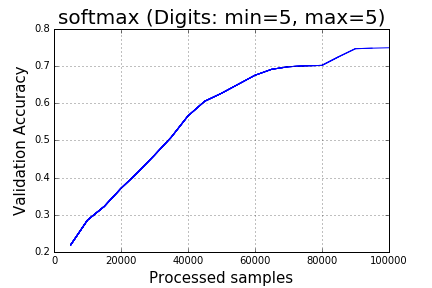

In [10]:
train_model(model_softmax)

In [11]:
#plot of validation accuracy for each target position
plt.figure(figsize=(7,7))
plt.plot(np.mean(np.argmax(model_softmax.output_val,axis=2)==t_out_val,axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()
#why do the plot look like this?

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


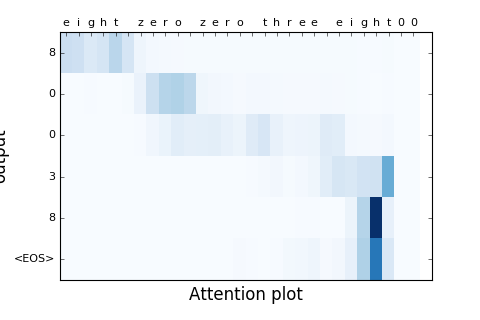

In [20]:
### attention plot, try with different i = 1, 2, ..., 1000
i = 100

column_labels = list(map(str, list(t_out_val[i])[:-1])) + ["<EOS>"]
row_labels = list(map(str, [valid_characters[l] for l in list(X_val[i])]))
data = model_softmax.alp_val[i]
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)

plt.ylabel('output', fontsize=15)
plt.xlabel('Attention plot', fontsize=15)

plt.savefig("attention_softmax_5.pdf")
plt.show()

In [13]:
#Plot of average attention weight as a function of the sequence position for each of 
#the 21 targets in the output sequence i.e. each line is the mean postion of the 
#attention for each target position.

np.mean(model_softmax.alp_val, axis=0).shape
plt.figure()
plt.plot(np.mean(model_softmax.alp_val, axis=0).T)
plt.ylabel('alpha', fontsize=15)
plt.xlabel('Input Sequence position', fontsize=15)
plt.title('Alpha weights', fontsize=20)
plt.legend(map(str,range(1,22)), bbox_to_anchor=(1.125,1.0), fontsize=10)
plt.show()


<IPython.core.display.Javascript object>

## run with sparsemax 5 digits (1 EOS)

In [16]:
reset_default_graph()
tf.set_random_seed(10)#42
Xs = tf.placeholder(tf.int32, shape=[None, None], name='X_input')
ts_in = tf.placeholder(tf.int32, shape=[None, None], name='t_input_in')
ts_out = tf.placeholder(tf.int32, shape=[None, None], name='t_input_out')
X_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_mask = tf.placeholder(tf.float32, shape=[None, None], name='t_mask')



model_sparsemax = RNN('sparsemax')
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
# test train part
sess.run(tf.initialize_all_variables())

feed_dict = {Xs: inputs, X_len: inputs_seqlen, ts_in: targets_in,
             ts_out: targets_out, t_len: targets_seqlen}
fetches = [model_sparsemax.y]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y", res[0].shape)

# test validation part
fetches = [model_sparsemax.y_valid]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y_valid", res[0].shape)

#Generate some validation data
X_val, X_len_val, t_in_val, t_out_val, t_len_val, t_mask_val, \
text_inputs_val, text_targets_in_val, text_targets_out_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
print("X_val", X_val.shape)
print("t_out_val", t_out_val.shape)

y (3, 6, 11)
y_valid (3, 6, 11)
X_val (5000, 29)
t_out_val (5000, 6)


Alpha: max=0.9413, min=0.0


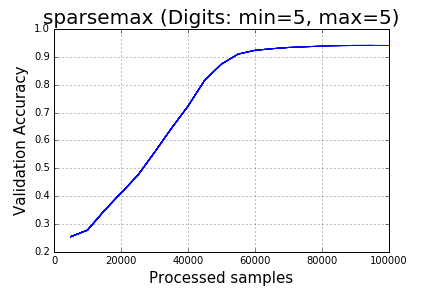

In [17]:
train_model(model_sparsemax)

<IPython.core.display.Javascript object>


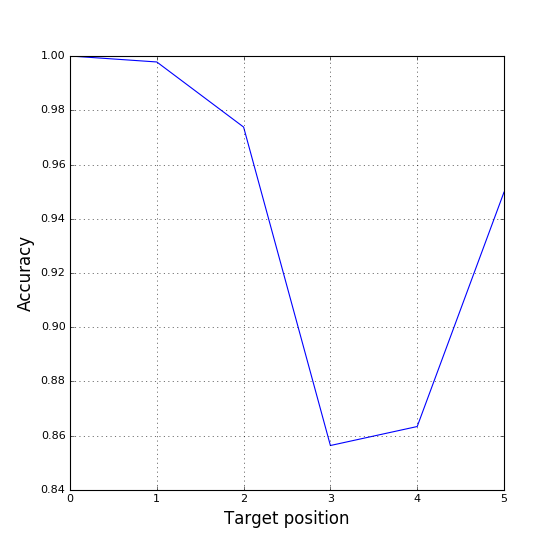

In [18]:
#plot of validation accuracy for each target position
plt.figure(figsize=(7,7))
plt.plot(np.mean(np.argmax(model_sparsemax.output_val,axis=2)==t_out_val,axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()
#why do the plot look like this?

<IPython.core.display.Javascript object>


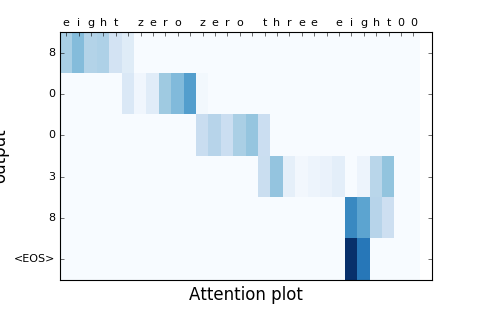

In [19]:
### attention plot, try with different i = 1, 2, ..., 1000
i = 100

column_labels = list(map(str, list(t_out_val[i])[:-1])) + ["<EOS>"]
row_labels = list(map(str, [valid_characters[l] for l in list(X_val[i])]))
data = model_sparsemax.alp_val[i]
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)

plt.ylabel('output', fontsize=15)
plt.xlabel('Attention plot', fontsize=15)

plt.savefig("attention_sparsemax.pdf")
plt.show()

In [ ]:
#Plot of average attention weight as a function of the sequence position for each of 
#the 21 targets in the output sequence i.e. each line is the mean postion of the 
#attention for each target position.

np.mean(model_sparsemax.alp_val, axis=0).shape
plt.figure()
plt.plot(np.mean(model_sparsemax.alp_val, axis=0).T)
plt.ylabel('alpha', fontsize=15)
plt.xlabel('Input Sequence position', fontsize=15)
plt.title('Alpha weights', fontsize=20)
plt.legend(map(str,range(1,22)), bbox_to_anchor=(1.125,1.0), fontsize=10)
plt.show()


## comparisons


In [ ]:
#print(str(row_labels))
#print(sum(sum(model_sparsemax.alp_val[42] !=0)))
#print(sum(sum(model_softmax.alp_val[42] >=0.01)))
# attention per sequence (the number of characters)
sum(sum(model_softmax.alp_val[3]))

<IPython.core.display.Javascript object>


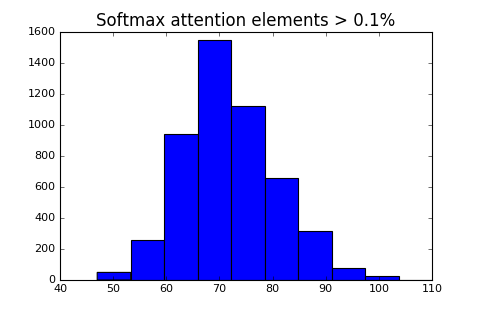

<IPython.core.display.Javascript object>


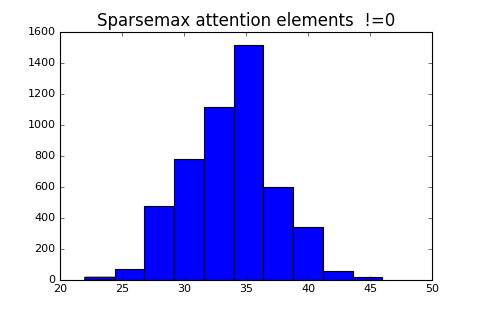

In [23]:
softmax_non_zeros = [sum(sum(x >= 6 / 1e3)) for x in model_softmax.alp_val]
sparsemax_non_zeros = [sum(sum(x != 0)) for x in model_sparsemax.alp_val]
plt.figure()
plt.hist(softmax_non_zeros)
plt.title("Softmax attention elements > 0.1%", fontsize=15)
plt.savefig("softmax_attention_greaterthan_hist.pdf")
plt.figure()
plt.hist(sparsemax_non_zeros)
plt.title("Sparsemax attention elements  !=0", fontsize=15)
plt.savefig("sparsemax_attention_nonzero_hist.pdf")
plt.show()

In [ ]:
#plt.figure()
#plt.hist(np.ravel(np.ravel(model_softmax.alp_val[42])), 25)
#plt.figure()
#plt.hist(np.ravel(np.ravel(model_sparsemax.alp_val[42])), 25)
#plt.show()

In [21]:
#accuracy on validation
print(np.mean(np.argmax(model_softmax.output_val,axis=2)==t_out_val))
print(np.mean(np.argmax(model_sparsemax.output_val,axis=2)==t_out_val))

0.749066666667
0.9402


In [ ]:
print(np.mean(np.argmax(model_sparsemax_conv_error.output_val,axis=2)==t_out_val))

## check on longer sequence softmax

In [24]:
MAX_DIGITS = 20
MIN_DIGITS = 20
samples_to_process = 2e5

In [25]:
reset_default_graph()
tf.set_random_seed(13)
Xs = tf.placeholder(tf.int32, shape=[None, None], name='X_input')
ts_in = tf.placeholder(tf.int32, shape=[None, None], name='t_input_in')
ts_out = tf.placeholder(tf.int32, shape=[None, None], name='t_input_out')
X_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_mask = tf.placeholder(tf.float32, shape=[None, None], name='t_mask')



model_softmax_long = RNN('softmax')
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
# test train part
sess.run(tf.initialize_all_variables())

feed_dict = {Xs: inputs, X_len: inputs_seqlen, ts_in: targets_in,
             ts_out: targets_out, t_len: targets_seqlen}
fetches = [model_softmax_long.y]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y", res[0].shape)

# test validation part
fetches = [model_softmax_long.y_valid]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y_valid", res[0].shape)

#Generate some validation data
X_val, X_len_val, t_in_val, t_out_val, t_len_val, t_mask_val, \
text_inputs_val, text_targets_in_val, text_targets_out_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
print("X_val", X_val.shape)
print("t_out_val", t_out_val.shape)

y (3, 6, 11)
y_valid (3, 6, 11)
X_val (5000, 111)
t_out_val (5000, 21)


Alpha: max=0.8225, min=0.0


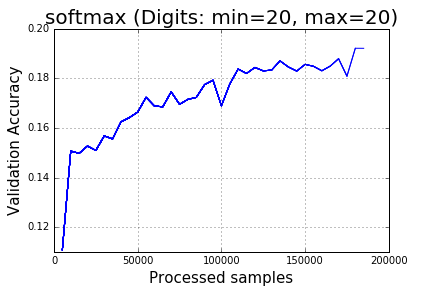

In [ ]:
train_model(model_softmax_long)

In [ ]:
### attention plot, try with different i = 1, 2, ..., 1000
i = 200

column_labels = list(map(str, list(t_out_val[i])[:-1])) + ["<EOS>"]
row_labels = list(map(str, [valid_characters[l] for l in list(X_val[i])]))
data = model_softmax_long.alp_val[i]
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False, fontsize=5)
ax.set_yticklabels(column_labels, minor=False, fontsize=5)
ax.set_aspect(1/0.5)
plt.ylabel('output', fontsize=10)
plt.xlabel('Attention plot', fontsize=10)

plt.savefig("attention_softmax_long.pdf")
plt.show()

## check on longer sequence sparsemax

In [ ]:
MAX_DIGITS = 20
MIN_DIGITS = 20

reset_default_graph()
tf.set_random_seed(134)
Xs = tf.placeholder(tf.int32, shape=[None, None], name='X_input')
ts_in = tf.placeholder(tf.int32, shape=[None, None], name='t_input_in')
ts_out = tf.placeholder(tf.int32, shape=[None, None], name='t_input_out')
X_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_mask = tf.placeholder(tf.float32, shape=[None, None], name='t_mask')



model_sparsemax_long = RNN('sparsemax')
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
# test train part
sess.run(tf.initialize_all_variables())

feed_dict = {Xs: inputs, X_len: inputs_seqlen, ts_in: targets_in,
             ts_out: targets_out, t_len: targets_seqlen}
fetches = [model_sparsemax_long.y]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y", res[0].shape)

# test validation part
fetches = [model_sparsemax_long.y_valid]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y_valid", res[0].shape)

#Generate some validation data
X_val, X_len_val, t_in_val, t_out_val, t_len_val, t_mask_val, \
text_inputs_val, text_targets_in_val, text_targets_out_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
print("X_val", X_val.shape)
print("t_out_val", t_out_val.shape)

In [ ]:
train_model(model_sparsemax_long)

In [ ]:
### attention plot, try with different i = 1, 2, ..., 1000
i = 200

column_labels = list(map(str, list(t_out_val[i])[:-1])) + ["<EOS>"]
row_labels = list(map(str, [valid_characters[l] for l in list(X_val[i])]))
data = model_sparsemax_long.alp_val[i]
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False, fontsize=5)
ax.set_yticklabels(column_labels, minor=False, fontsize=5)
ax.set_aspect(1/0.5)
plt.ylabel('output', fontsize=10)
plt.xlabel('Attention plot', fontsize=10)

plt.savefig("attention_sparsemax_long.pdf")
plt.show()